In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Analysis and Modelling of TOI 197

In [2]:
q = pd.read_table('freqs', delim_whitespace=True)

l = q['l'].values
ν = q['ν'].values
e_ν = q['e_ν'].values
cl = q['class'].values

## Modelling without detailed frequencies

From Bill's email, the stellar properties are as follows:

```
<Dnu> = 28.94 ± 0.15 uHz, from linear fit to reported l=0 frequencies

Teff = 5080 +/- 90
[Fe/H] = -0.08 +/- 0.08

The Gaia constraints are as follows:
Parallax: 10.5180 +/- 0.0795 mas (after applying 80uas offset)
Luminosity: 5.15 +/- 0.17 solar luminosities (mean + scatter of results by Keivan, Barry and Dan)
```

In [3]:
T_eff = 5080
e_T_eff = 90

FeH = -0.08
e_FeH = 0.08

logL = np.log10(5.15)
e_logL = 0.17/5.15 * np.log(10)

In [4]:
from astropy import units as u, constants as c

# with Gaia parallaxes, we can impose constraints on the radius

R = (np.sqrt(5.15 * c.L_sun / (4 * np.pi * c.sigma_sb * (T_eff * u.K)**4))/c.R_sun).to(1).value
e_R = 1/2 * np.sqrt((0.17/5.15)**2 + 4 * (e_T_eff / T_eff)**2) * R

logR = np.log10(R)
e_logR = e_R/R *  np.log(10)

In [5]:
from mesa_tricks.opt import Δν_fit

l0mask = (l == 0) #& (cl == 1)

ν0 = ν[l0mask]
e_ν0 = e_ν[l0mask]

ν2 = ν[l == 2]
e_ν2 = e_ν[l == 2]

trial_Δν = np.median(np.diff(ν0))

Δν, e_Δν, ls = Δν_fit(ν0, ν0 // trial_Δν, σ_ν=e_ν0)

print(f'Δν = {Δν:.2f} ± {e_Δν:.2f} μHz')

Δν = 29.05 ± 0.14 μHz


In [6]:
from mesa_tricks.io import read_track, read_index
from mesa_tricks.costs import bg_fit
from mesa_tricks.utils import merge_closest_mask

from os import system
from os.path import isfile
from scipy.signal import argrelextrema
from yabox import DE

In [7]:
LOG_ZX_SOLAR = np.log10(0.02293)
Χ2_SPECTRO_LIMIT = 1/2
χ2_L0_LIMIT = 20

def pulse(gyrefile, min, max, l):
    outfile = gyrefile.replace('.data.GYRE', f'-{l:d}-freqs.dat')
    
    if not isfile(outfile):
        system(f"./pulse.sh {gyrefile} {min} {max} {l:d}")
    df = pd.read_table(outfile, delim_whitespace=True, skiprows=5)
    return df

def memoised_dispatch(PP, regen=False, prefix='.'):
    M, Y, R = PP
    try:
        memoiser = np.load(f'{prefix}/memo.npy')[()]
    except:
        memoiser = {}
    if prefix == '.'  and ((PP not in memoiser.keys()) or regen):
        system(f"./create_profiles.sh {M} {Y} {R} > /dev/null")
        ID = len(memoiser.keys())
        track = f'tracks/LOGS_{ID:d}'
        system(f"mv tracks/LOGS_test {track}")
        memoiser[PP] = track
        np.save("memo", memoiser)
    else:
        track = memoiser[PP]
        
    return track

def seismo_cost(track, profile, ν, e_ν, l, trace=False, prefix='.'):
    
#     ν0 = ν[l==0]
#     e_ν0 = e_ν[l==0]
    
#     ν2 = ν[l==2]
#     e_ν2 = e_ν[l==2]
    
    l0model = pulse(f'{prefix}/{track}/profile{profile:d}.data.GYRE', 400, 520, 0)
    ν0_model = l0model['Re(freq)'].values
    E0 = l0model['E_norm'].values
    n_p0 = l0model['n_p'].values
    m02, m01 = merge_closest_mask(ν0, ν0_model)
    
    χ2_fit = ((Δν_fit(ν0_model[m01], n_p0[m01])[0] / 1.0109 - Δν) / e_Δν)**2        
    χ2_low_n = np.sum(((ν0[m02][:2] - ν0_model[m01][:2]) / e_ν0[m02][:2])**2) / 2
    
    if χ2_fit + χ2_low_n > χ2_L0_LIMIT:
        return np.inf

    l2model = pulse(f'{prefix}/{track}/profile{profile:d}.data.GYRE', 400, 500, 2)
    E2 = l2model['E_norm'].values
    m = argrelextrema(E2, np.less)

    ν2_model = l2model['Re(freq)'].values[m]
    n_p2 = l2model['n_p'].values[m]
    E2 = E2[m]
    m22, m21 = merge_closest_mask(ν2, ν2_model)

    j_bg = bg_fit(ν0[m02], ν0_model[m01], E0[m01], σ_ν=e_ν0[m02], r=True, xtol=0, trace=trace)
#     χ2_bg = j_bg['cost'] * 2
    
    bg_res = lambda ν_o, ν_m, E, σ_ν, am1, a3, r: ((ν_o - (r * ν_m + (am1/ν_m + a3*ν_m**3)/E))/σ_ν)
    
    res = bg_res(
            np.concatenate((ν0[m02], ν2[m22])),
            np.concatenate((ν0_model[m01], ν2_model[m21])),
            np.concatenate((E0[m01], E2[m21])),
            np.concatenate((e_ν0[m02], e_ν2[m22])),
            *j_bg['x']
          )
    χ2_bg = np.sum(res**2) / (np.sum(m02) + np.sum(m22) - 4)
    
    if trace:
        print(res)
        print(j_bg)
        print(χ2_bg, χ2_fit, χ2_low_n)
    
    return χ2_bg + χ2_fit + χ2_low_n

def track_cost(P, makeplots=False, prefix='.'):

    # 1.2 0.27 0l02
    # gives χ^2_spectro = 0.3
    
    M, Y, R = P
    PP = M, Y, R
    track = memoised_dispatch(PP, prefix=prefix)
    
    df1 = read_track(f'{prefix}/{track}/history.data')
    df2 = read_index(f'{prefix}/{track}/')
    
    df = pd.merge(df1, df2, on='model_number')
    
    feh = np.array(df['log_surf_cell_z'] - df['log_surface_h1'] - LOG_ZX_SOLAR)
    teff = np.array(df['effective_T'])
    logr = np.array(df['log_R'])
    logl = np.array(df['log_L'])
    
    χ2_spectro = (0
        + ((feh - FeH) / e_FeH)**2
        + ((teff - T_eff) / e_T_eff)**2
        + ((logr - logR) / e_logR)**2
        + ((logl - logL) / e_logL)**2
    ) / 4
    
    χ2_seismo = np.ones_like(χ2_spectro) * np.inf
    
    for i, (q, m) in enumerate(zip(χ2_spectro, df['profile'])):
        if q < Χ2_SPECTRO_LIMIT:
            χ2_seismo[i] = seismo_cost(track, m, ν, e_ν, l, prefix=prefix)
            
    if makeplots:
        plt.scatter(df['effective_T'], df['log_L'], c=np.exp(-χ2_spectro))
        plt.gca().invert_xaxis()
        plt.colorbar()
        plt.show()
        
        plt.scatter(df['effective_T'], df['log_L'], c=np.exp(-χ2_seismo))
        plt.gca().invert_xaxis()
        plt.colorbar()
        plt.show()
        
        idx = np.argmin(χ2_spectro + χ2_seismo)
        print(df.loc[idx])
        seismo_cost(track, df.profile[idx], ν, e_ν, l, trace=True, prefix=prefix)
            
    return χ2_seismo, χ2_spectro

def cost(P, **kwargs):
    χ2_seismo, χ2_spectro = track_cost(P, **kwargs)
        
    return np.min(χ2_seismo + χ2_spectro)

In [ ]:
de = DE(cost, [(1.18, 1.24), (0.25, 0.29), (0.015, 0.025)], maxiters=20, seed=42)
res = de.solve(show_progress=True)
res

/opt/anaconda3/lib/python3.6/site-packages/scipy/optimize/_lsq/least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))
Optimizing (DE):  10%|█         | 2/20 [1:05:44<9:51:43, 1972.44s/it]

In [16]:
# (array([[1.22965701, 0.28310467, 0.02327617],
#         [1.19773467, 0.26182312, 0.01795578],
#         [1.21832682, 0.27555121, 0.0213878 ]]), 10.19555784479438)

In [8]:
args = np.array(list(np.load('memo.npy')[()].keys()))

In [9]:
from tqdm import tqdm_notebook
costs = np.array([cost(a) for a in tqdm_notebook(args)])

/opt/anaconda3/lib/python3.6/site-packages/scipy/optimize/_lsq/least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


In [9]:
args_coarse = np.array(list(np.load('coarse/memo.npy')[()].keys()))
# costs_coarse = np.array([cost(a, prefix='coarse') for a in tqdm_notebook(args_coarse)])

In [38]:
np.min(costs)

5.324410188206044

In [39]:
np.min(costs_coarse)

5.813618275086106

tracks/LOGS_51


/opt/anaconda3/lib/python3.6/site-packages/scipy/optimize/_lsq/least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


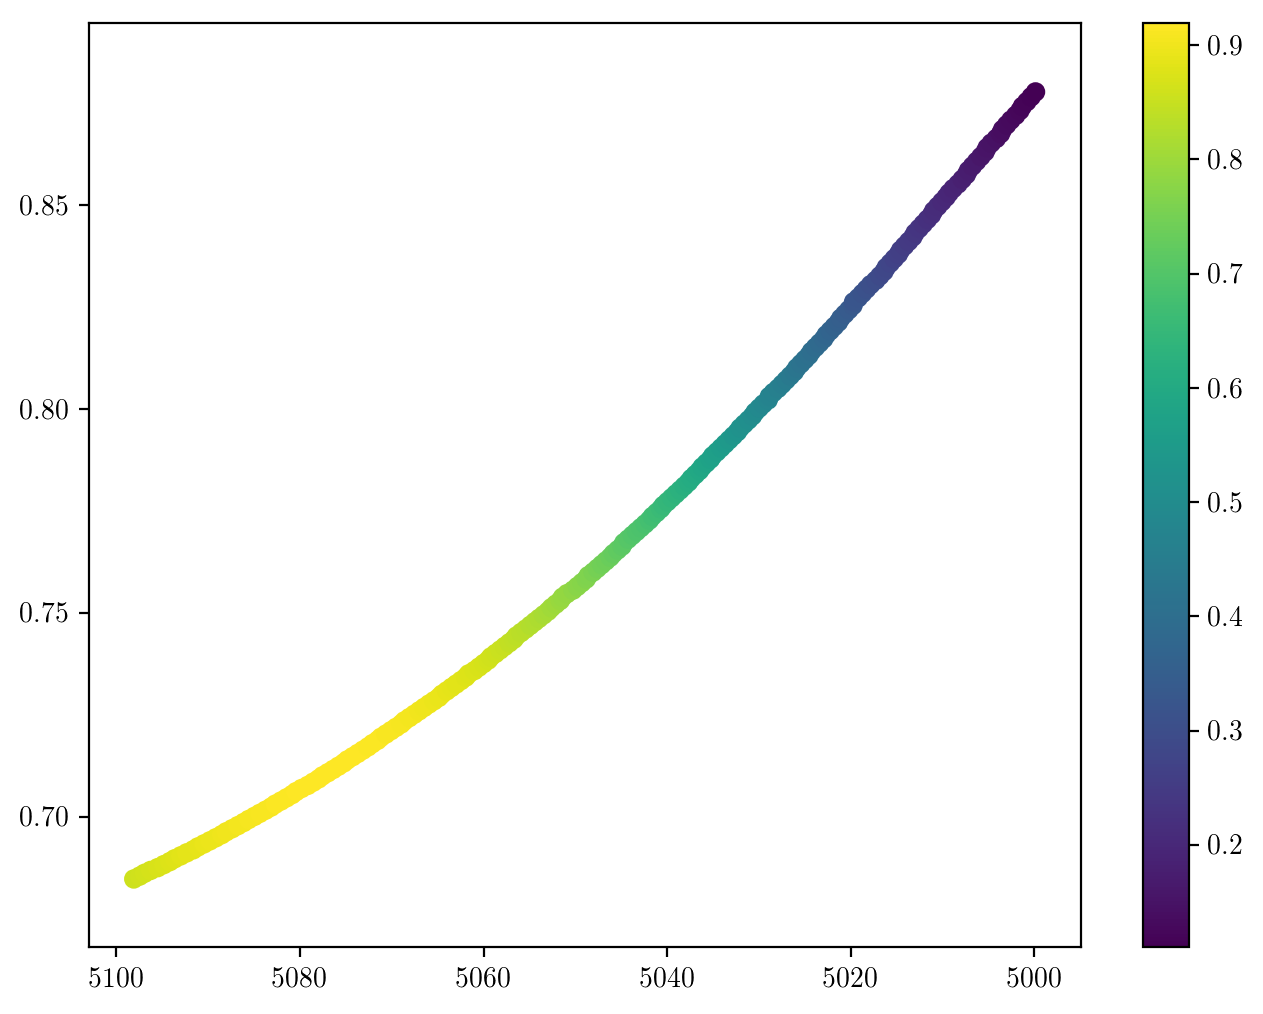

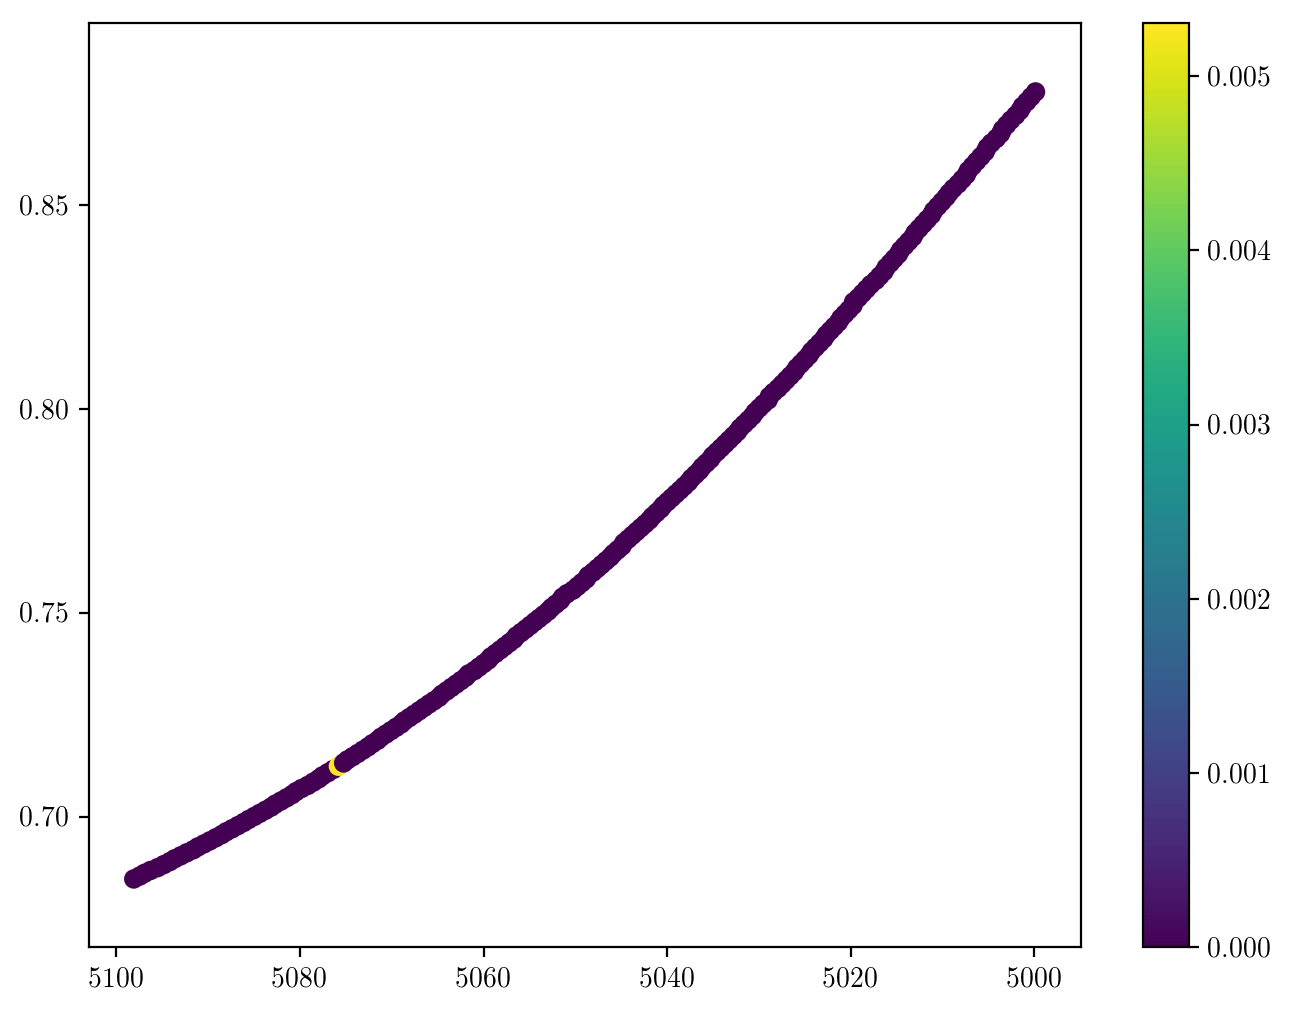

model_number              9.850000e+02
num_zones                 1.183000e+03
star_age                  4.939903e+09
star_mass                 1.203392e+00
mass_conv_core            0.000000e+00
he_core_mass              1.617421e-01
c_core_mass               0.000000e+00
o_core_mass               0.000000e+00
si_core_mass              0.000000e+00
fe_core_mass              0.000000e+00
neutron_rich_core_mass    0.000000e+00
effective_T               5.075819e+03
log_L                     7.123855e-01
log_R                     4.684393e-01
log_g                     3.581418e+00
log_surf_cell_z          -1.908077e+00
v_div_csound_surf         1.685124e-11
log_surface_h1           -1.420654e-01
delta_nu                  3.144856e+01
nu_max                    4.602442e+02
priority                  1.000000e+00
profile                   3.800000e+01
Name: 37, dtype: float64
ν_obs: [420.06 448.89 478.07 507.49]
ν_model: [419.92541747 449.21275152 478.60543147 508.26085619]
E: [3.63934533e-0

/opt/anaconda3/lib/python3.6/site-packages/scipy/optimize/_lsq/least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


5.324410188206044

In [45]:
print(np.load('memo.npy')[()][tuple(args[np.argmin(costs)])])

cost(args[np.argmin(costs)], makeplots=True)

tracks/LOGS_332


/opt/anaconda3/lib/python3.6/site-packages/scipy/optimize/_lsq/least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


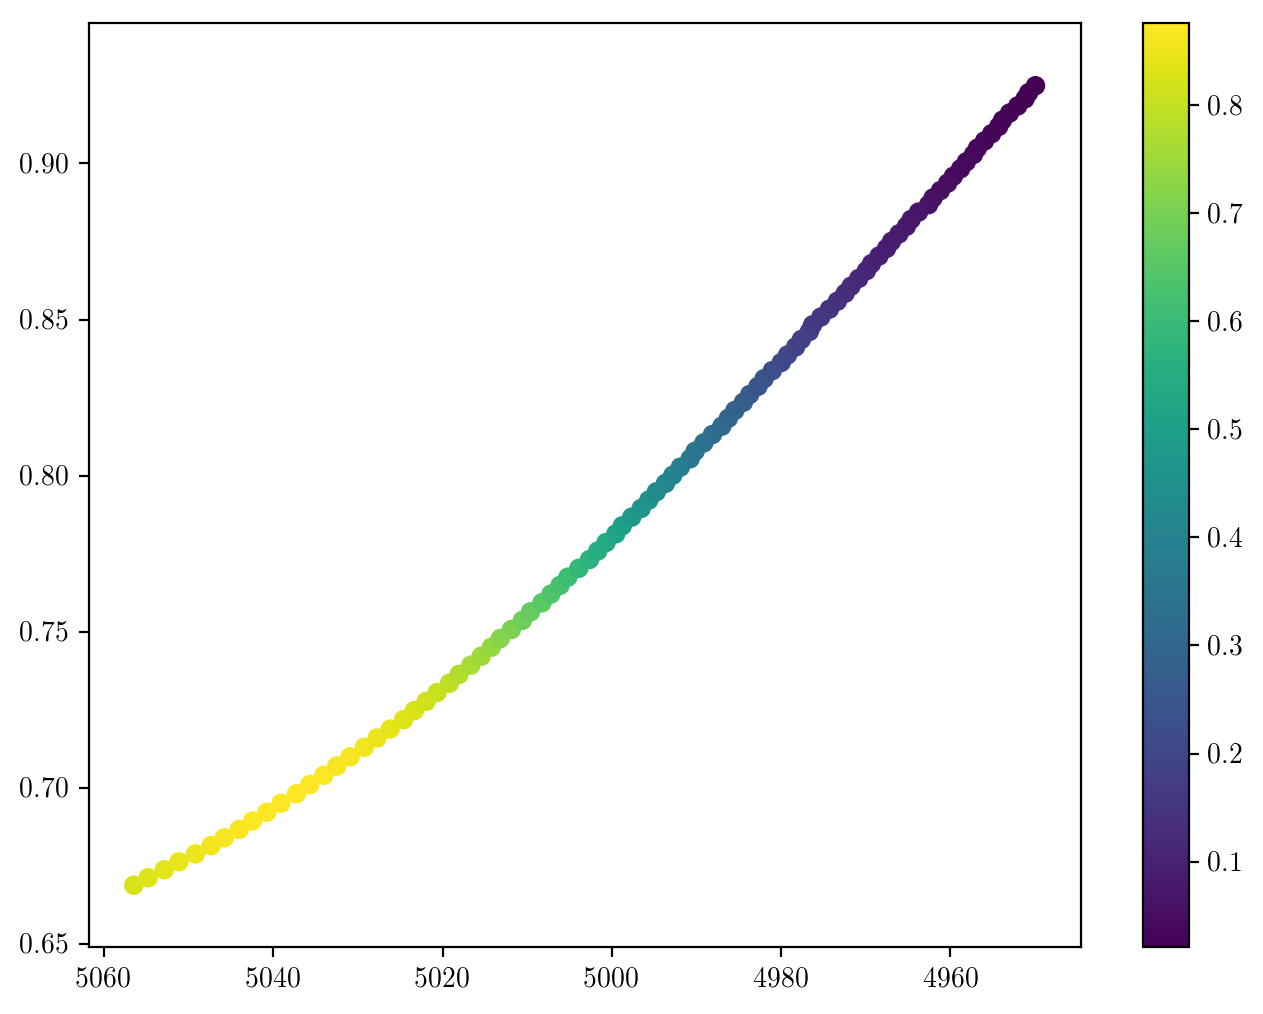

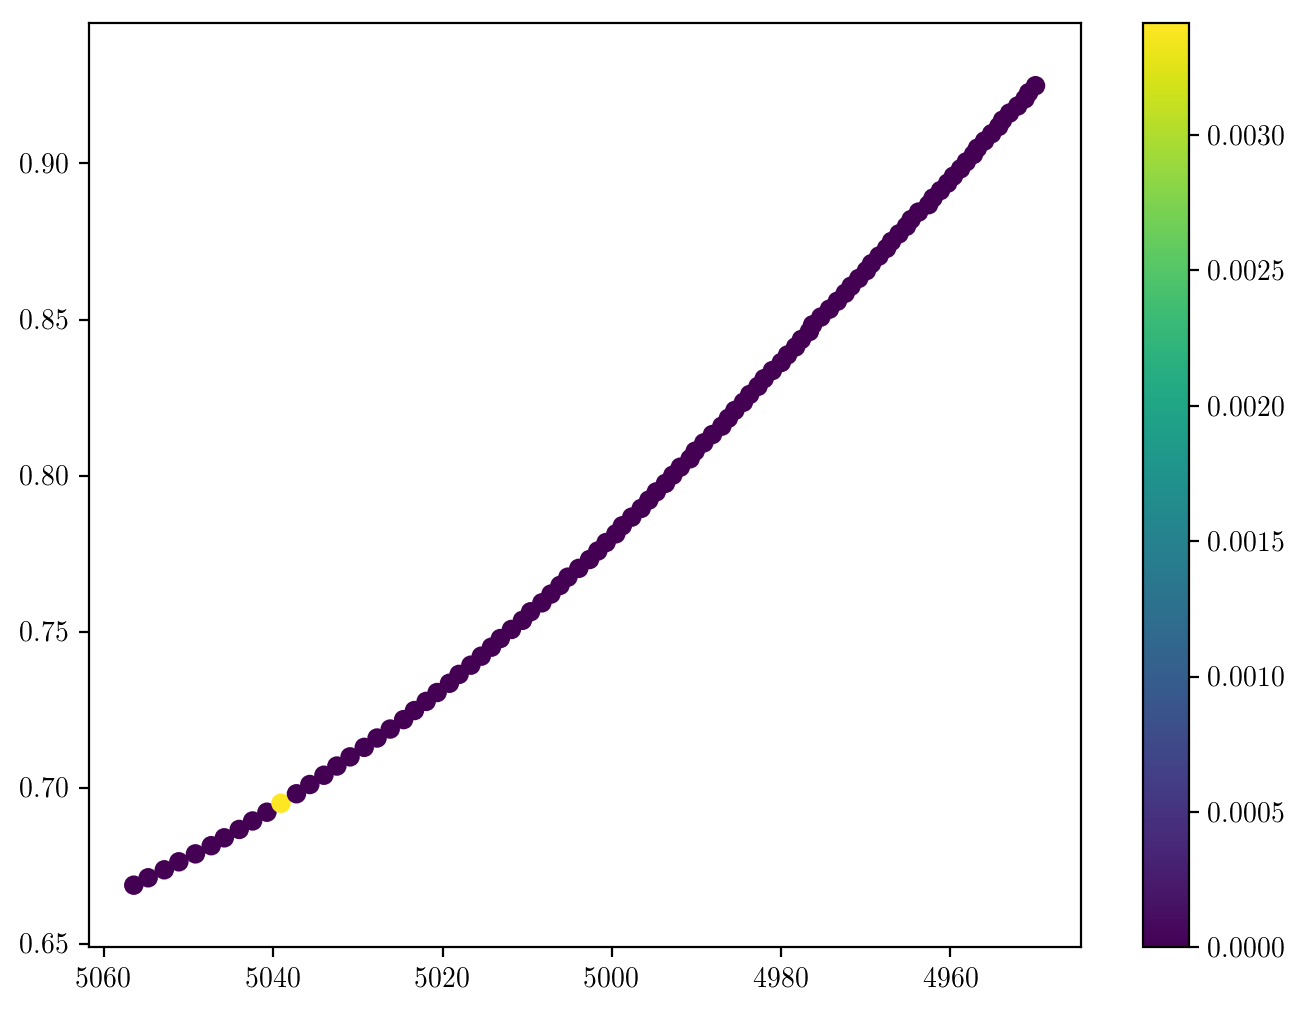

model_number              9.730000e+02
num_zones                 1.198000e+03
star_age                  5.605593e+09
star_mass                 1.185185e+00
mass_conv_core            0.000000e+00
he_core_mass              1.607201e-01
c_core_mass               0.000000e+00
o_core_mass               0.000000e+00
si_core_mass              0.000000e+00
fe_core_mass              0.000000e+00
neutron_rich_core_mass    0.000000e+00
effective_T               5.039093e+03
log_L                     6.950194e-01
log_R                     4.660638e-01
log_g                     3.579548e+00
log_surf_cell_z          -1.898968e+00
v_div_csound_surf         1.525590e-11
log_surface_h1           -1.372339e-01
delta_nu                  3.145724e+01
nu_max                    4.599339e+02
priority                  1.000000e+00
profile                   3.100000e+01
Name: 10, dtype: float64
ν_obs: [420.06 448.89 478.07 507.49]
ν_model: [420.01929037 449.30832158 478.7439379  508.43300822]
E: [3.55937579e-0

/opt/anaconda3/lib/python3.6/site-packages/scipy/optimize/_lsq/least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


5.813618275086106

In [46]:
print(np.load('coarse/memo.npy')[()][tuple(args_coarse[np.argmin(costs_coarse)])])

cost(args_coarse[np.argmin(costs_coarse)], makeplots=True, prefix='coarse')

In [27]:
coarse_mask = costs_coarse != np.inf

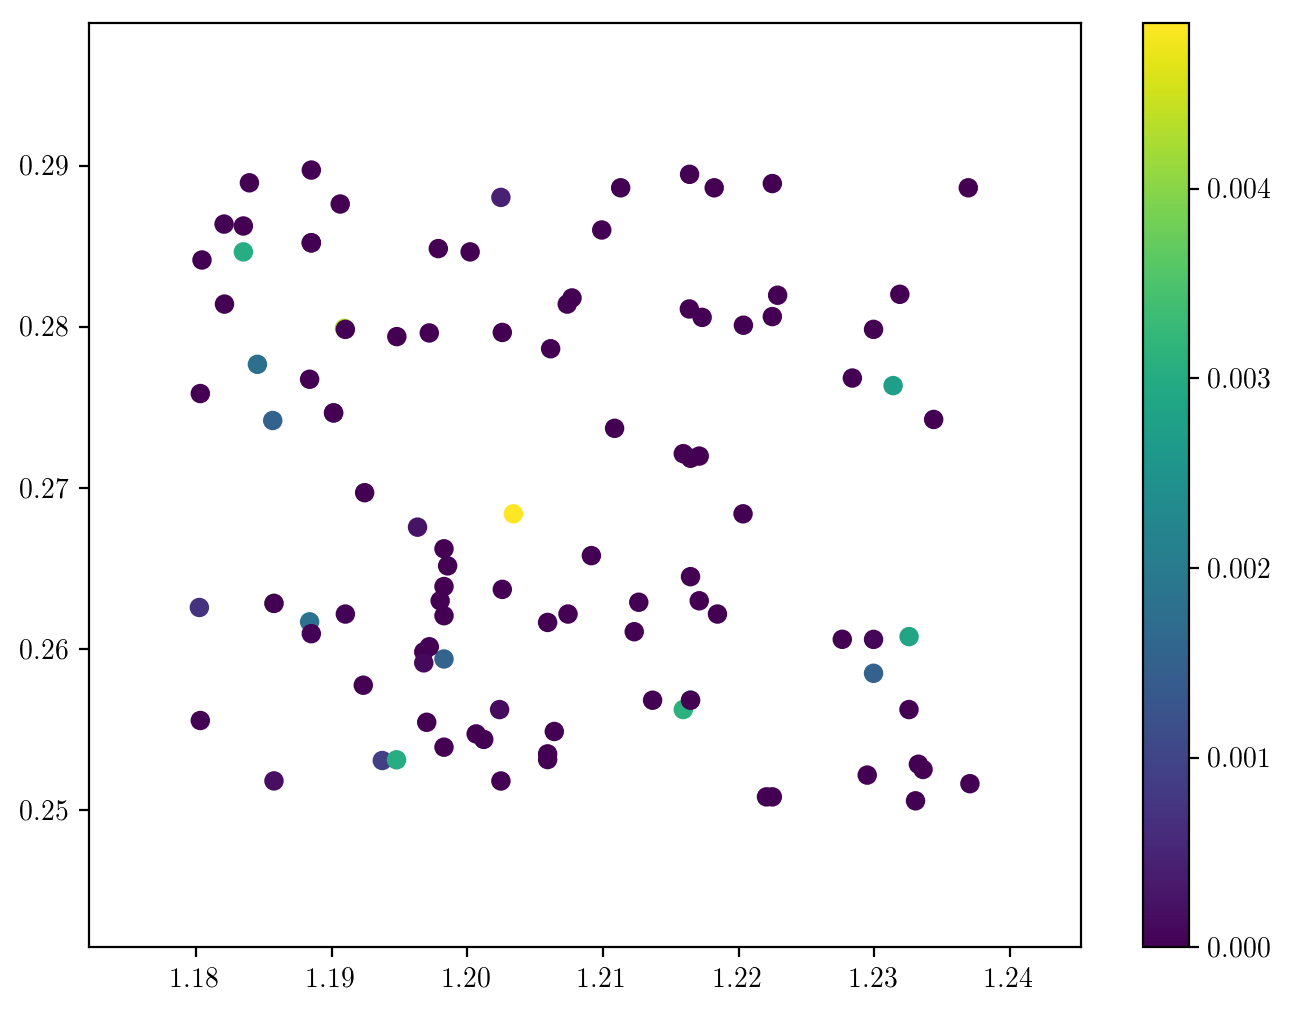

In [12]:
plt.scatter(args[:,0], args[:,1], c=np.exp(-costs))
plt.colorbar()
plt.show()

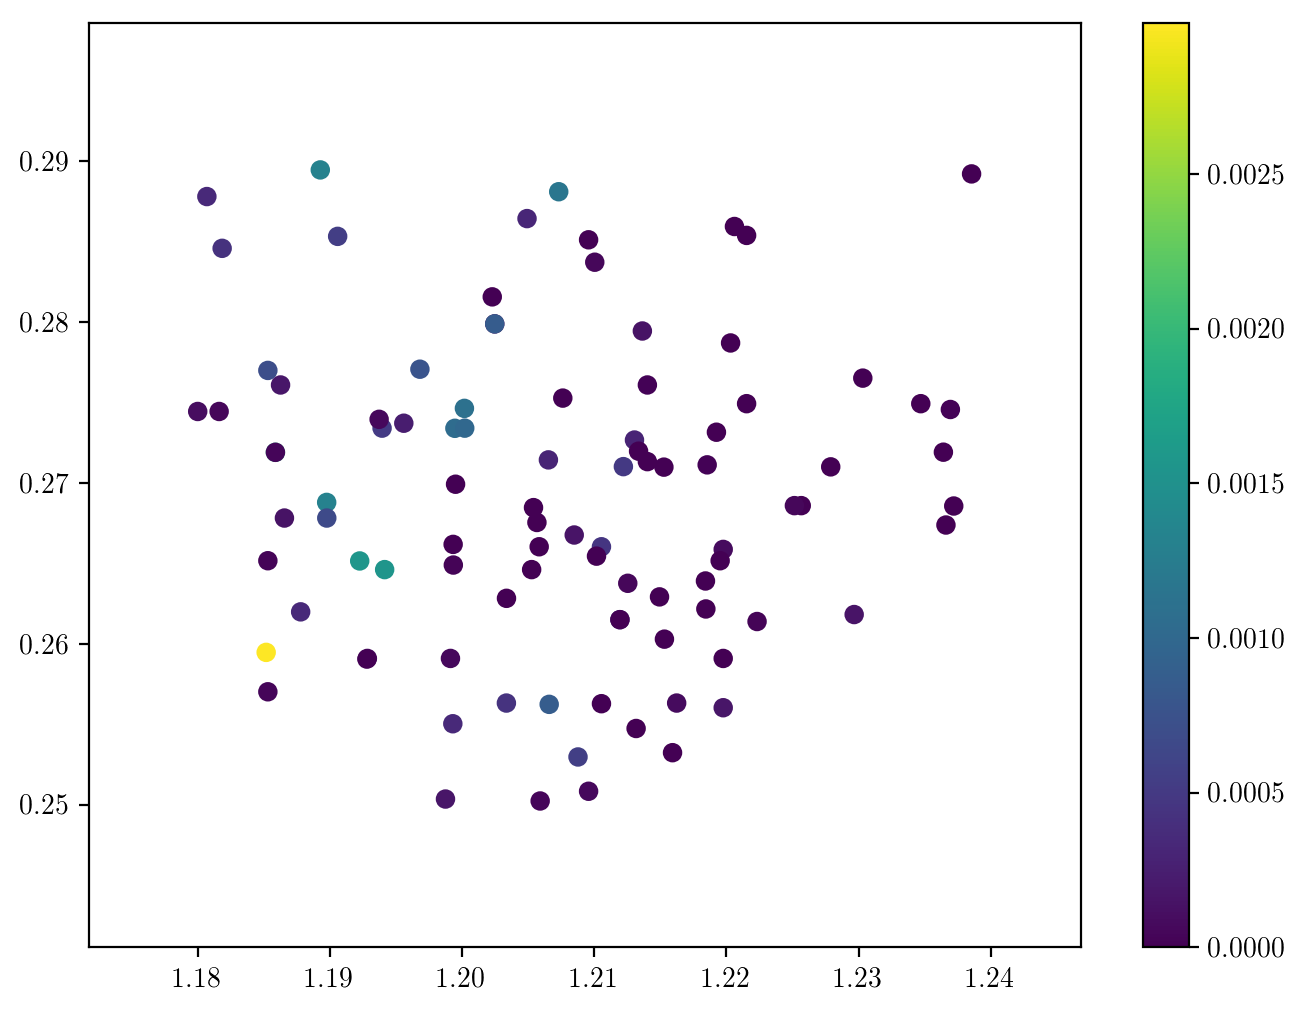

In [28]:
plt.scatter(args_coarse[coarse_mask,0], args_coarse[coarse_mask,1], c=np.exp(-costs_coarse[coarse_mask]))
plt.colorbar()
plt.show()

In [ ]:
de.iterator()

In [11]:
args = res[0][0]

In [ ]:
cost(args)

In [9]:
# from scipy.optimize import differential_evolution

# differential_evolution(cost, [(1.18, 1.22), (0.22, 0.26), (0.012070571585744767, 0.030319904986797364)], maxiter=400)

In [11]:
Χ2_SPECTRO_LIMIT = 1/4
def track_properties(P, makeplots=False, prefix='.'):

    M, Y, R = P
    PP = M, Y, R
    track = memoised_dispatch(PP, prefix=prefix)
    
    df1 = read_track(f'{prefix}/{track}/history.data')
    df2 = read_index(f'{prefix}/{track}/')
    
    df = pd.merge(df1, df2, on='model_number')
    
    feh = np.array(df['log_surf_cell_z'] - df['log_surface_h1'] - LOG_ZX_SOLAR)
    teff = np.array(df['effective_T'])
    logr = np.array(df['log_R'])
    logl = np.array(df['log_L'])
    
    χ2_spectro = (0
        + ((feh - FeH) / e_FeH)**2
        + ((teff - T_eff) / e_T_eff)**2
#         + ((logr - logR) / e_logR)**2
#         + ((logl - logL) / e_logL)**2
    ) / 2
    
    χ2_seismo = np.ones_like(χ2_spectro) * np.inf
    
    for i, (q, m) in enumerate(zip(χ2_spectro, df['profile'])):
        if q < Χ2_SPECTRO_LIMIT:
            χ2_seismo[i] = seismo_cost(track, m, ν, e_ν, l, prefix=prefix)
            
    return (np.ones_like(feh) * M, np.ones_like(feh) * Y, np.ones_like(feh) * R, df['star_age'].values, feh, teff, np.power(10, logr), np.power(10, logl), np.exp(-χ2_spectro), np.exp(-χ2_seismo))

In [12]:
from tqdm import tqdm_notebook
props = ([track_properties(a) for a in tqdm_notebook(list(np.load('memo.npy')[()].keys()))])
props_coarse = ([track_properties(a, prefix='coarse') for a in tqdm_notebook(list(np.load('coarse/memo.npy')[()].keys()))])

/opt/anaconda3/lib/python3.6/site-packages/scipy/optimize/_lsq/least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


In [13]:
arr = np.array([np.concatenate([p[i] for p in props]) for i in range(len(props[0]))])
arr_coarse = np.array([np.concatenate([p[i] for p in props_coarse]) for i in range(len(props[0]))])

In [14]:
np.save("unbinned", np.hstack((arr, arr_coarse)))

In [15]:
props_all = np.load('unbinned.npy')

In [101]:
from scipy.stats import gaussian_kde

k = gaussian_kde(props_all[:4])

prior_pdf = k(props_all[:4])

np.save('prior_unbinned', prior_pdf)

In [18]:
prior_pdf = np.load('prior_unbinned.npy')

In [24]:
likelihoods = props_all[-2] * props_all[-1]

In [25]:
import astropy.constants as c
quantities = [props_all[6], props_all[0], props_all[0]/props_all[6]**3 * (c.M_sun /(4/3 * np.pi)/c.R_sun**3).cgs.value, props_all[7], props_all[3]]
# radius, mass, density, luminosity, age

means = [np.average(p, weights=likelihoods/prior_pdf) for p in quantities]
C2 = [np.sqrt(np.average((p - μ)**2, weights=likelihoods/prior_pdf)) for p, μ in zip(quantities, means)]
C3 = [np.average(((p - μ)/σ)**3, weights=likelihoods/prior_pdf) for p, μ, σ in zip(quantities, means, C2)]

In [26]:
# names = ['M', 'Y', 'Z/X', 'age', 'feh', 'teff', 'r', 'l']
names = ['R', 'M', 'ρ', 'L', 'age']

for μ, σ, name, κ in zip(means, C2, names, C3):
    print("{}: {:.5e} ± {:.5e} (κ = {:.3f})".format(name, μ, σ, κ))

R: 2.93701e+00 ± 1.25423e-02 (κ = 1.114)
M: 1.19956e+00 ± 1.47544e-02 (κ = 1.135)
ρ: 6.67499e-02 ± 4.82559e-05 (κ = -0.146)
L: 5.07907e+00 ± 1.24500e-01 (κ = 0.832)
age: 5.06492e+09 ± 3.65119e+08 (κ = -0.407)


In [27]:
for μ, σ, name, κ in zip(means, C2, names, C3):
    print("{}: {}, {}, {}".format(name, μ, μ + σ, μ - σ))

R: 2.9370131710174157, 2.9495554798225347, 2.9244708622122966
M: 1.1995628860251193, 1.2143172751855027, 1.1848084968647359
ρ: 0.06674985819182498, 0.06679811413536887, 0.06670160224828109
L: 5.079073993505702, 5.203574277144733, 4.954573709866671
age: 5064923605.742155, 5430042913.959615, 4699804297.524695


In [28]:
from scipy.stats import norm
from wquantiles import quantile

data = np.array([quantile(np.array(quantities), likelihoods/prior_pdf, norm.cdf(i)) for i in [0, 1, -1]]).T
data

array([[2.93203097e+00, 2.94686998e+00, 2.92459136e+00],
       [1.19414607e+00, 1.21194033e+00, 1.18518548e+00],
       [6.67545992e-02, 6.68035707e-02, 6.67131150e-02],
       [5.05805088e+00, 5.15992393e+00, 4.95479751e+00],
       [4.97210987e+09, 5.45093709e+09, 4.89041267e+09]])

In [29]:
table = np.array([[μ, high - μ, μ - low] for μ, high, low in data])
np.savetxt("out.dat", [table.flatten()])
table

array([[2.93203097e+00, 1.48390054e-02, 7.43960796e-03],
       [1.19414607e+00, 1.77942548e-02, 8.96059424e-03],
       [6.67545992e-02, 4.89714484e-05, 4.14842254e-05],
       [5.05805088e+00, 1.01873044e-01, 1.03253369e-01],
       [4.97210987e+09, 4.78827221e+08, 8.16972005e+07]])

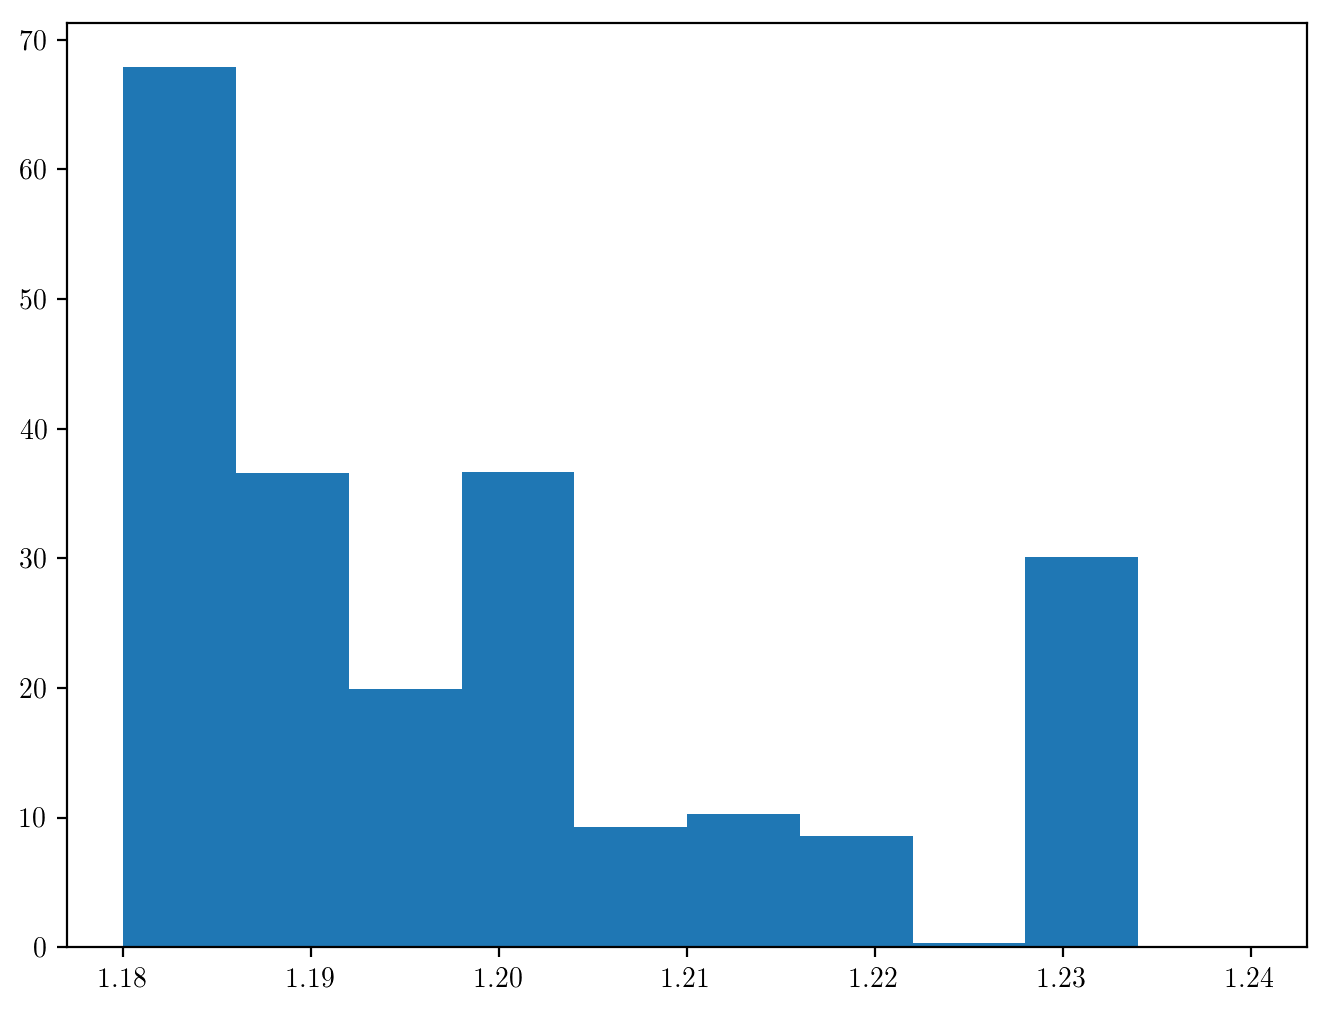

In [122]:
plt.hist(props_all[0], weights=likelihoods/prior_pdf, bins=10)
# plt.gca().set_yscale('log')
plt.show()

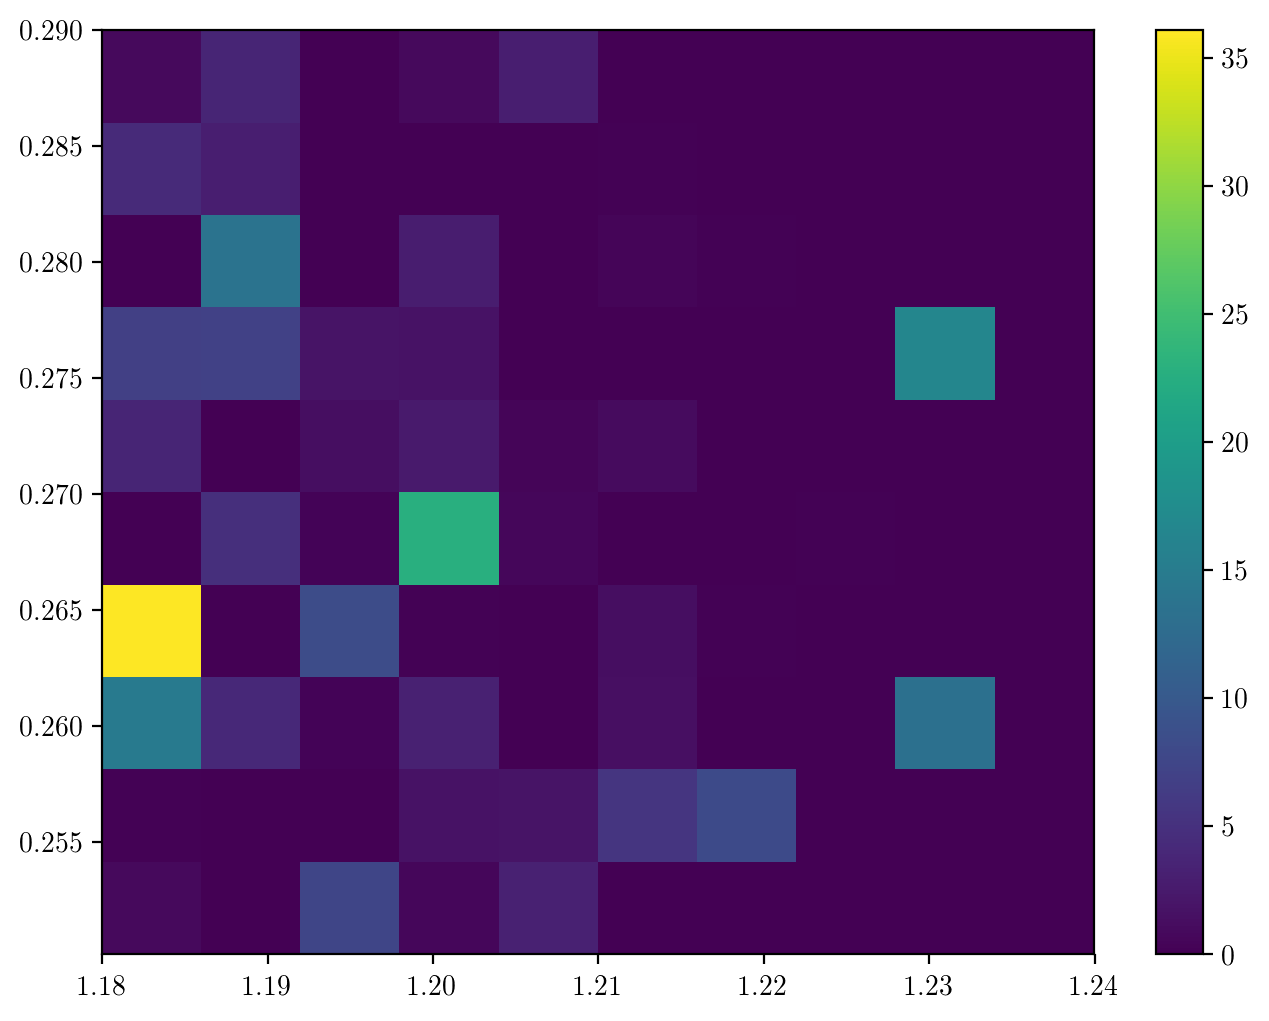

In [129]:
plt.hist2d(props_all[0], props_all[1], weights=likelihoods/prior_pdf, bins=10)
plt.colorbar()
plt.show()